In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data/final_no_edit_needed.csv')
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
#outlıer elımınatıon
df = df[(df['Engagement_Total']<1000)]
df = df.groupby('source').filter(lambda x : len(x)>10)
df = df.reset_index(drop=True)
words = ["#"]
df["check_hashtags"] = df.text.apply(lambda x: sum([x.count(word) for word in words]))


In [ ]:
!pip install textstat
import textstat
def readingscore(text):

    score = textstat.flesch_reading_ease(text)
    
    return score

df['flesch_reading'] = df['text_preprocessed'].apply(readingscore)

#outlıer elımınatıon
df = df[(df['flesch_reading']>-900)]
df = df.reset_index(drop=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.xlim(-75,150)
plt.xlabel('Flesch Reading Score')
plt.ylabel('Density')
sns.kdeplot(df['flesch_reading'],shade=True)
plt.show()

In [ ]:
#pd.set_option('display.max_columns', None)

In [ ]:
#df.sort_values(by='flesch_reading', ascending=True)

# Data Import

In [ ]:
# checking if there are any duplicates by id column
duplicateRowsDF = df[df.duplicated(['id'])]
duplicateRowsDF

# Profanity Probability

In [ ]:
!pip install alt-profanity-check
from profanity_check import predict, predict_prob

In [ ]:
df["profanity_probability"] = np.nan
for i in range(df.shape[0]):
    df['profanity_probability'][i] = str(predict_prob([df['text_preprocessed'][i]]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df['profanity_probability'] = df['profanity_probability'].map(lambda x: x.lstrip('['))
df['profanity_probability'] = df['profanity_probability'].map(lambda x: x.rstrip(']'))
df['profanity_probability'] = df['profanity_probability'].astype(float)

In [ ]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
display(df)

# Classifying Classes

In [ ]:
df = df.loc[:, df.columns.isin(["id","author_id",
                           "created_at","text","source","public_metrics.like_count",
                           "public_metrics.quote_count","public_metrics.reply_count","public_metrics.retweet_count","possibly_sensitive",
                           "author.id","author.created_at","author.public_metrics.followers_count",
                           "author.public_metrics.listed_count","author.public_metrics.tweet_count",
                           'time_diff_hours','Engagement_Total','text_preprocessed','avg_length_words',
                            'emoji_count','text_preprocessed_nostopwords','created_at_hour','check_hashtags',
                            'check_media','check_poll', 'day','day_name',
                            'url_count','mention_count','text_preprocessed_emotion_scores','text_preprocessed_sentiment','flesch_reading','text_preprocessed_emotion_heading', 'profanity_probability'])]
        

In [ ]:
#Deciding on class ranges
df[(df['Engagement_Total']>0)][['Engagement_Total']].describe()

In [ ]:
def engagement_class(x):
    if (x == 0):
        y = 'None'
    if (x > 0) & (x < 2) :
        y = 'Low'
    if (x > 1) & (x < 9) :
        y = 'Moderate'
    if (x > 8) :
        y = 'High'
    return y

In [ ]:
df['Engagement_Total_Class'] = df['Engagement_Total'].apply(engagement_class)

In [ ]:
# Plot frequency of users, sources, etc.
import seaborn as sns
import matplotlib.pyplot as plt
def plot_frequency_charts(df, feature, title):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} '.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
#final distribution
plot_frequency_charts(df, 'Engagement_Total_Class', 'Engagement_Total_Class')

# New Features

In [ ]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import pytz
from datetime import datetime, timedelta
import pandas as pd

now = datetime.now(tz=pytz.utc)
df["account_duration"] = ((now - pd.to_datetime(df["author.created_at"])).dt.total_seconds())/3600
df["account_duration"] = df["account_duration"]/24

In [ ]:
df['text_length'] = df['text'].apply(len)

In [ ]:
df['source'] = df['source'].fillna('null')

In [ ]:
df[['public_metrics.like_count', 'public_metrics.reply_count', 'public_metrics.retweet_count', 'Engagement_Total']].describe()

,public_metrics.like_count,public_metrics.reply_count,public_metrics.retweet_count,Engagement_Total
count,91320.000000,91320.000000,91320.000000,91320.000000
mean,4.794930,0.553800,0.943638,6.292367
std,25.717698,3.758762,7.292934,32.409546
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,2.000000,0.000000,0.000000,3.000000
max,920.000000,531.000000,488.000000,996.000000


# Cross-Fold Target Encoding

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=11, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [ ]:
te = TargetEncoderCV()
le = LabelEncoder()

In [ ]:
df_new = df[[
        #'possibly_sensitive',
        #'time_diff_hours', 'check_poll',
         'flesch_reading',
         'mention_count','url_count', 
        # 'check_media', 
        'check_hashtags',
         'avg_length_words',
        'emoji_count', 'text_length', 
        'author.public_metrics.listed_count',
        'author.public_metrics.followers_count', 'author.public_metrics.tweet_count', 
        'profanity_probability', 
        'account_duration'
       ]]

In [ ]:
df_new2 = df[[ 'day_name', 
              'source', 
        'text_preprocessed_sentiment', 'text_preprocessed_emotion_heading',
        'possibly_sensitive',
        'check_media'
        #, 'check_hashtags'
        ]]

In [ ]:
df_new2 = te.fit_transform(df_new2, df['Engagement_Total']).astype(float)

In [ ]:
df_new = pd.merge(df_new, df_new2, left_index=True, right_index=True)

In [ ]:
#df_new["possibly_sensitive"] = df_new["possibly_sensitive"].astype(int)

In [ ]:
# Check the skew of all numerical features
numeric_feats = df_new.dtypes[df_new.dtypes != "object"].index
skewed_feats = df_new[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
author.public_metrics.tweet_count,21.628692
author.public_metrics.listed_count,21.562640
emoji_count,12.180211
mention_count,7.937806
possibly_sensitive,7.608901
check_hashtags,5.110646
author.public_metrics.followers_count,3.130796
profanity_probability,2.783748
check_media,1.196436
url_count,1.180037


In [ ]:
import numpy as np
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
pt.fit(df_new)
lambdas = pd.DataFrame({'cols':df_new.columns,"box-cox-lambdas":pt.lambdas_})
print(pt.lambdas_)

[  1.25191409  -9.14084521  -1.61751693  -3.74675914   0.57168592
  -4.22485786   0.18849225  -0.46803262   0.11108877   0.10447331
  -8.55360934   0.26495621   9.62986294   1.72365992  -4.58437679
  -0.99644155 -87.82934939  -5.38741426]


In [ ]:
 for col in df_new.columns:
        t = pt.fit_transform(np.array(df_new[col]).reshape(-1,1))
        df_new[col] = t.reshape(-1)

In [ ]:
# from scipy.special import boxcox1p
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# for feat in skewed_features:    
#     df_new[feat] = boxcox1p(df_new[feat], lambdas.loc[lambdas['cols'] == feat, 'box-cox-lambdas'].iloc[0])


There are 18 skewed numerical features to Box Cox transform


In [ ]:
# Check the skew of all numerical features
numeric_feats = df_new.dtypes[df_new.dtypes != "object"].index
skewed_feats = df_new[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
possibly_sensitive,7.608901
mention_count,2.355788
emoji_count,1.446441
check_media,1.196436
profanity_probability,0.826361
url_count,0.397400
author.public_metrics.listed_count,0.317388
text_preprocessed_sentiment,0.300435
text_preprocessed_emotion_heading,0.109830
avg_length_words,0.027040


In [ ]:
X = df_new

In [ ]:
Y = df['Engagement_Total_Class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5346854)
#7

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Comparing All the Models without Tuning

In [ ]:
X_test['flesch_reading'] = X_test['flesch_reading'].fillna(0)
X_train['flesch_reading'] = X_train['flesch_reading'].fillna(0)
X['flesch_reading'] = X['flesch_reading'].fillna(0)


In [ ]:
!pip install CatBoost
from catboost import CatBoostClassifier

     |████████████████████████████████| 76.6 MB 72 kB/s 


In [ ]:
!pip install lightgbm
import lightgbm as lgb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xgboost
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

classifiers = [
    CatBoostClassifier(),
    lgb.LGBMClassifier(),
    KNeighborsClassifier(3),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LogisticRegression()]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import scipy.stats
log_cols=["Classifier", 'F1 Score', 'ci_lower', 'ci_upper' ]
log = pd.DataFrame(columns=log_cols)

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*40)
    print(name)

    train_predictions = clf.predict(X_test)
    f1 = f1_score(y_test, train_predictions, average='micro')
    ci_length = z_value * np.sqrt((f1 * (1 - f1)) / y_test.shape[0])
    ci_lower = f1 - ci_length
    ci_upper = f1 + ci_length

    print("F1 Score: {}".format(f1))
    
    
    log_entry = pd.DataFrame([[name, f1, ci_lower, ci_upper ]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*40)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

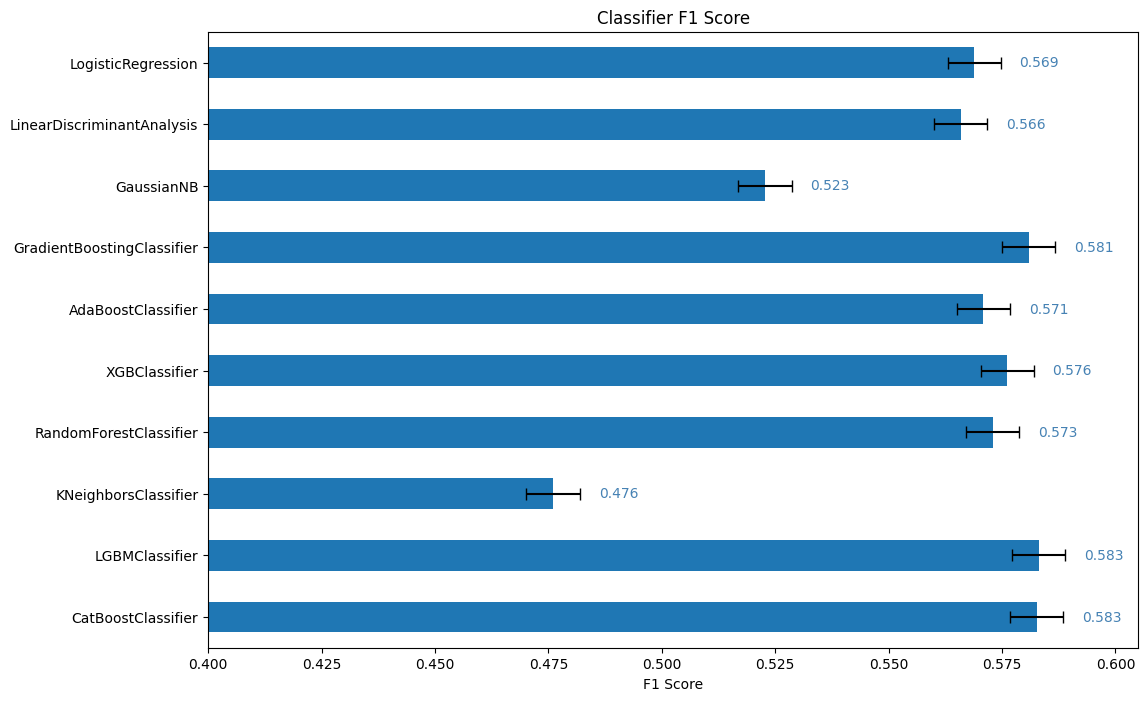

In [ ]:
log.reset_index(drop=True)
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import math
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,8))

g = (log['F1 Score'].plot.barh(xerr=log['F1 Score'] - log['ci_lower'],
                     ax=ax, capsize=4)
)
ax.set_yticklabels(log['Classifier'])
ax.set_xlim(0.4, 0.605)

for i, v in enumerate(log['F1 Score']):
    plt.text(v+0.010, i, str(round(v, 3)), color='steelblue', va="center")


plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')
plt.savefig("all_models.pdf", bbox_inches='tight')
files.download("all_models.pdf")
plt.show()

# Bootstrapping Confidence Interval

In [ ]:
#clf = XGBClassifier()
#clf = lgb.LGBMClassifier()
#clf = CatBoostClassifier()
clf = LogisticRegression()
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
bootstrap_train_accuracies = []

for i in range(200):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    
    boot_train_X, boot_train_y = X_train2.loc[train_idx], y_train2.loc[train_idx]
    boot_test_X, boot_test_y = X_train2.loc[test_idx], y_train2.loc[test_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_predictions = clf.predict(boot_test_X)
    acc = f1_score(boot_test_y, train_predictions, average='micro')
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean


0.5585527557936977

In [ ]:
bootstrap_rounds = 200
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)
se = 0.0
for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

print(ci_lower, ci_upper)

0.5536973307568731 0.5634081808305222


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

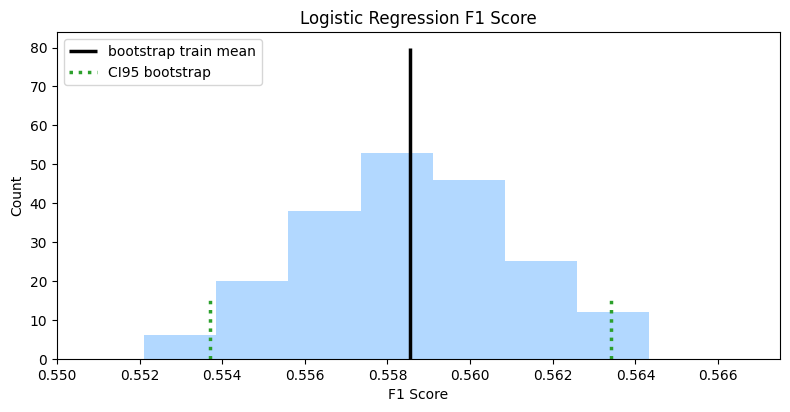

In [ ]:
from google.colab import files
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines( bootstrap_train_mean, [0], 80, lw=2.5, linestyle='-', label='bootstrap train mean')

ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle='dotted', 
          label='CI95 bootstrap', color='C2')
ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.hist(bootstrap_train_accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.55, 0.5675])
plt.xlabel('F1 Score')
plt.ylabel('Count')
plt.tight_layout()
plt.title('Logistic Regression F1 Score')
plt.savefig("lr3_ci.pdf", bbox_inches='tight')
files.download("lr3_ci.pdf")
plt.show()


In [ ]:
clf = XGBClassifier()
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
bootstrap_train_accuracies = []

for i in range(30):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    
    boot_train_X, boot_train_y = X_train2.loc[train_idx], y_train2.loc[train_idx]
    boot_test_X, boot_test_y = X_train2.loc[test_idx], y_train2.loc[test_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_predictions = clf.predict(boot_test_X)
    acc = f1_score(boot_test_y, train_predictions, average='micro')
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean
bootstrap_rounds = 30
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)
se = 0.0
for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

print(ci_lower, ci_upper)




0.5582685277110929 0.5724116719149311


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

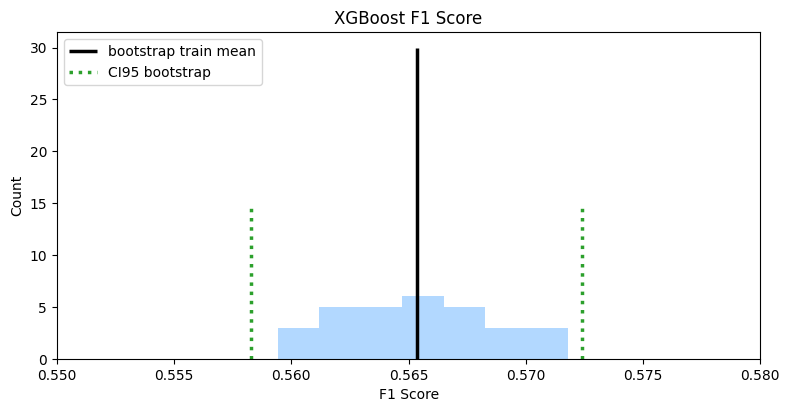

In [ ]:
from google.colab import files
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines( bootstrap_train_mean, [0], 30, lw=2.5, linestyle='-', label='bootstrap train mean')

ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle='dotted', 
          label='CI95 bootstrap', color='C2')
ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.hist(bootstrap_train_accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.55, 0.58])
plt.xlabel('F1 Score')
plt.ylabel('Count')
plt.tight_layout()
plt.title('XGBoost F1 Score')
plt.savefig("xg2_ci.pdf", bbox_inches='tight')
files.download("xg2_ci.pdf")
plt.show()


In [ ]:
clf = lgb.LGBMClassifier()
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
bootstrap_train_accuracies = []

for i in range(30):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    
    boot_train_X, boot_train_y = X_train2.loc[train_idx], y_train2.loc[train_idx]
    boot_test_X, boot_test_y = X_train2.loc[test_idx], y_train2.loc[test_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_predictions = clf.predict(boot_test_X)
    acc = f1_score(boot_test_y, train_predictions, average='micro')
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean
bootstrap_rounds = 30
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)
se = 0.0
for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

print(ci_lower, ci_upper)





0.5640985672685677 0.5762921230553355


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

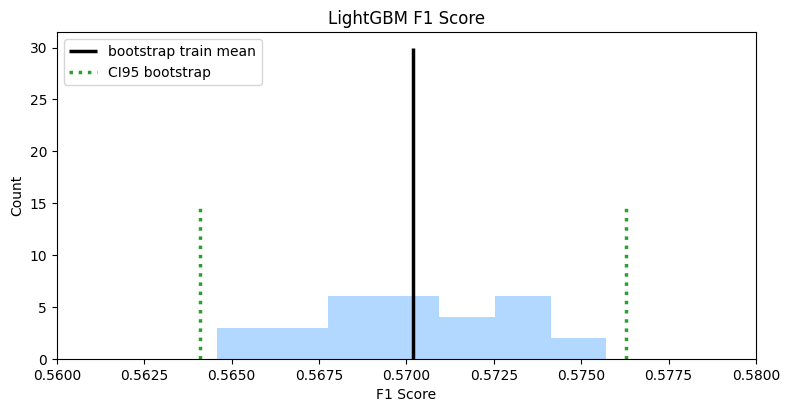

In [ ]:
from google.colab import files
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines( bootstrap_train_mean, [0], 30, lw=2.5, linestyle='-', label='bootstrap train mean')

ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle='dotted', 
          label='CI95 bootstrap', color='C2')
ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.hist(bootstrap_train_accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.56, 0.58])
plt.xlabel('F1 Score')
plt.ylabel('Count')
plt.tight_layout()
plt.title('LightGBM F1 Score')
plt.savefig("gbm2_ci.pdf", bbox_inches='tight')
files.download("gbm2_ci.pdf")
plt.show()

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss", 'F1 Score']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*40)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    train_predictions = clf.predict(X_test)
    f1 = f1_score(y_test, train_predictions, average='micro')
    print("F1 Score: {}".format(f1))
    
    
    log_entry = pd.DataFrame([[name, acc*100, ll, f1]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*40)

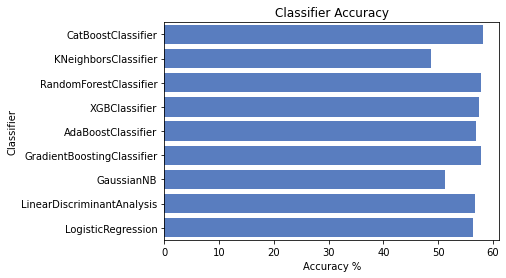

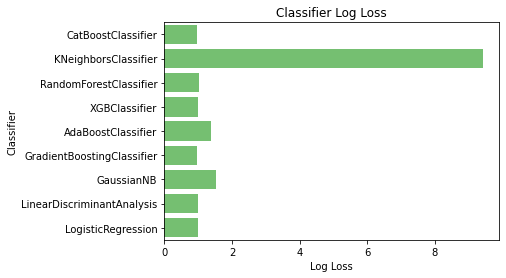

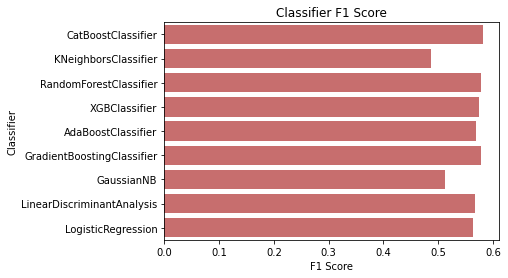

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='F1 Score', y='Classifier', data=log, color="r")

plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')
plt.show()

# Grouping the feature sets

In [ ]:
log_cols=["Feature Group", "F1 Score"]
log = pd.DataFrame(columns=log_cols)


In [ ]:
X_lexical = df_new[['mention_count', 'url_count', 'avg_length_words',
                        'emoji_count', 'text_length', 'possibly_sensitive', 'check_hashtags',  'check_media'	
                        ]]
Y_lexical = df['Engagement_Total_Class']
X_train_lexical, X_test_lexical, y_train_lexical, y_test_lexical = train_test_split(X_lexical, Y_lexical, test_size=0.3, random_state=5346854)


X_metadata = df_new[['author.public_metrics.listed_count', 
                   'author.public_metrics.followers_count', 
                   'author.public_metrics.tweet_count','account_duration', 
                   'day_name', 'source']]
Y_metadata = df['Engagement_Total_Class']
X_train_metadata, X_test_metadata, y_train_metadata, y_test_metadata = train_test_split(X_metadata, Y_metadata, test_size=0.3, random_state=5346854)

X_NLP =df_new[['text_preprocessed_sentiment', 
                   'text_preprocessed_emotion_heading', 'flesch_reading', 'profanity_probability']]
Y_NLP = df['Engagement_Total_Class']
X_train_NLP, X_test_NLP, y_train_NLP, y_test_NLP = train_test_split(X_NLP, Y_NLP, test_size=0.3, random_state=5346854)






In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                         min_split_gain =0.0169,
                         reg_alpha = 0.001,
    )
clf.fit(X_train_lexical, y_train_lexical)
# predict the results
y_pred=clf.predict(X_test_lexical)
# view accuracy
f1 = f1_score (y_test_lexical, y_pred, average='micro')
print("F1 Score: {}".format(f1))

log = log.append(pd.DataFrame([['Tweet', f1]], columns=log_cols))

F1 Score: 0.5092349248065411


In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                         min_split_gain =0.0169,
                         reg_alpha = 0.001,
    )
clf.fit(X_train_metadata, y_train_metadata)
# predict the results
y_pred=clf.predict(X_test_metadata)
# view accuracy
f1 = f1_score (y_test_metadata, y_pred, average='micro')
print("F1 Score: {}".format(f1))
log = log.append(pd.DataFrame([['Metadata', f1]], columns=log_cols))

F1 Score: 0.5564680975324865


In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                         min_split_gain =0.0169,
                         reg_alpha = 0.001,
    )
clf.fit(X_train_NLP, y_train_NLP)
# predict the results
y_pred=clf.predict(X_test_NLP)
# view accuracy
f1 = f1_score (y_test_NLP, y_pred, average='micro')
print("F1 Score: {}".format(f1))

log = log.append(pd.DataFrame([['Text', f1]], columns=log_cols))

F1 Score: 0.49879544459045116


In [ ]:
X_NLP_met =df_new[['author.public_metrics.listed_count', 
                   'author.public_metrics.followers_count', 
                   'author.public_metrics.tweet_count','account_duration', 
                   'day_name', 'source',
               'text_preprocessed_sentiment', 
                   'text_preprocessed_emotion_heading', 'flesch_reading', 'profanity_probability'
               ]]
Y_NLP_met = df['Engagement_Total_Class']
X_train_NLP_met, X_test_NLP_met, y_train_NLP_met, y_test_NLP_met = train_test_split(X_NLP_met, Y_NLP_met, test_size=0.3, random_state=5346854)



In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                         min_split_gain =0.0169,
                         reg_alpha = 0.001,
    )
clf.fit(X_train_NLP_met, y_train_NLP_met)
# predict the results
y_pred=clf.predict(X_test_NLP_met)
# view accuracy
f1 = f1_score (y_test_NLP_met, y_pred, average='micro')
print("F1 Score: {}".format(f1))
log = log.append(pd.DataFrame([['Text + Metadata', f1]], columns=log_cols))

F1 Score: 0.5614688275660681


In [ ]:
X_lex_met =df_new[['author.public_metrics.listed_count', 
                   'author.public_metrics.followers_count', 
                   'author.public_metrics.tweet_count','account_duration', 
                   'day_name', 'source',
              'mention_count', 'url_count', 'avg_length_words',
                        'emoji_count', 'text_length', 'possibly_sensitive', 'check_hashtags',  'check_media'	
               ]]
Y_lex_met = df['Engagement_Total_Class']
X_train_lex_met, X_test_lex_met, y_train_lex_met, y_test_lex_met = train_test_split(X_lex_met, Y_lex_met, test_size=0.3, random_state=5346854)



In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                         min_split_gain =0.0169,
                         reg_alpha = 0.001,
    )
clf.fit(X_train_lex_met, y_train_lex_met)
# predict the results
y_pred=clf.predict(X_test_lex_met)
# view accuracy
f1 = f1_score (y_test_lex_met, y_pred, average='micro')
print("F1 Score: {}".format(f1))
log = log.append(pd.DataFrame([['Tweet + Metadata', f1]], columns=log_cols))

F1 Score: 0.5841728719521098


In [ ]:
X_all =df_new[['author.public_metrics.listed_count', 
                   'author.public_metrics.followers_count', 
                   'author.public_metrics.tweet_count','account_duration', 
                   'day_name', 'source',
              'mention_count', 'url_count', 'avg_length_words',
                        'emoji_count', 'text_length', 'possibly_sensitive', 'check_hashtags',  'check_media'	,
               'text_preprocessed_sentiment', 
                   'text_preprocessed_emotion_heading', 'flesch_reading', 'profanity_probability'
               ]]
Y_all = df['Engagement_Total_Class']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, Y_all, test_size=0.3, random_state=5346854)




In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                         min_split_gain =0.0169,
                         reg_alpha = 0.001,
    )
clf.fit(X_train_all, y_train_all)
# predict the results
y_pred=clf.predict(X_test_all)
# view accuracy
f1 = f1_score (y_test_all, y_pred, average='micro')
print("F1 Score: {}".format(f1))

log = log.append(pd.DataFrame([['Tweet + Text + Metadata', f1]], columns=log_cols))

F1 Score: 0.5852679223244269


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

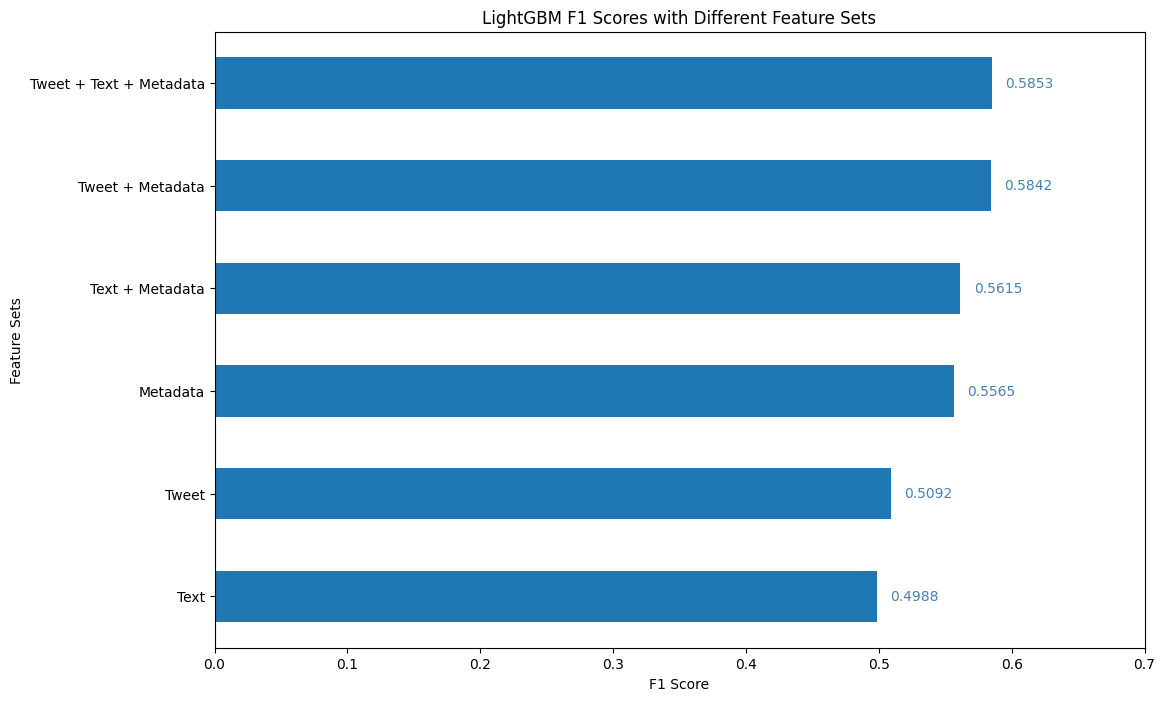

In [ ]:
log.reset_index(drop=True)
log.sort_values('F1 Score',inplace=True)
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import math
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,8))

g = (log['F1 Score'].plot.barh(
                     ax=ax)
)
ax.set_yticklabels(log['Feature Group'])
ax.set_xlim(0, 0.7)

for i, v in enumerate(log['F1 Score']):
    plt.text(v+0.010, i, str(round(v, 4)), color='steelblue', va="center")


plt.xlabel('F1 Score')
plt.ylabel('Feature Sets')
plt.title('LightGBM F1 Scores with Different Feature Sets')
plt.savefig("feature_sets.pdf", bbox_inches='tight')
files.download("feature_sets.pdf")
plt.show()

# Catboost

In [ ]:
!pip install CatBoost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [ ]:
CBC = CatBoostClassifier()
parameters = {'depth'         : [7,8,9, 10],
                 'learning_rate' : [0.01,0.05, 0.07, 0.09],
                  'iterations'    : [100]
             # 'loss_function' :  ['f1_score']
                 }

In [ ]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5)
Grid_CBC.fit(X_train, y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [ ]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5)
Grid_CBC.fit(X_train, y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [ ]:
def objective(trial):
    
    params = {'iterations':trial.suggest_int("iterations", 100, 500),
              #'od_wait':trial.suggest_int('od_wait', 500, 3200),
             'loss_function':'MultiClass',
              'eval_metric':'TotalF1',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              #'subsample': trial.suggest_uniform('subsample',0,1),
              #'random_strength': trial.suggest_uniform('random_strength',10,30),
              'depth': trial.suggest_int('depth',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,8),
               }
    model = CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    f1 = f1_score(y_test, y_preds, average= 'micro')
    
    return f1

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Number of finished trials: 24
Best trial:
  Value: 0.5859614542268944
  Params: 
    iterations: 389
    od_wait: 1996
    learning_rate: 0.1477165986570529
    reg_lambda: 56.499561470376044
    random_strength: 24.928946670296153
    depth: 5
    min_data_in_leaf: 18
    leaf_estimation_iterations: 5


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
cat_model = CatBoostClassifier( 
    iterations= 389,
    #od_wait= 1996,
    learning_rate= 0.1,
    reg_lambda= 56.499561470376044,
    depth= 5,
    #min_data_in_leaf= 18,
    leaf_estimation_iterations= 5,
    eval_metric = "TotalF1",
    random_state =42
                                                          )
#1.06025346 2.2145116 1.7237214, 0.49379734
cat_model.fit(X_train, y_train)

#predict on test set
test_predictions = cat_model.predict(X_test)

print( f1_score(y_test, test_predictions, average= 'micro') )
#calculate test score
#cat_y_test = [(x) for x in y_test]
#score = cat_model.score(X_test, list(cat_y_test))
#print(score)

#irony ile 0.53579 dan 0.5376ya yükseldi 
#0.5741145605596851den  0.5784324442501093 yüksel permutation ile
#'depth': 8, 'iterations': 700, 'learning_rate': 0.03
#depth = 8, iterations = 500, learning_rate = 0.04

In [ ]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [ ]:
cat_model = CatBoostClassifier(  depth = 7,  learning_rate = 0.09,
                               eval_metric = "TotalF1"
                              # class_weights = {'None': 0.49379734, 'Low': 1.06025346, 'Moderate': 1.7237214, 'High' :2.2145116}
                               )
#1.06025346 2.2145116 1.7237214, 0.49379734
cat_model.fit(X_train, y_train)

#predict on test set
test_predictions = cat_model.predict(X_test)


#calculate test score
cat_y_test = [(x) for x in y_test]
score = cat_model.score(X_test, list(cat_y_test))
print(score)

#irony ile 0.53579 dan 0.5376ya yükseldi 
#0.5741145605596851den  0.5784324442501093 yüksel permutation ile
#'depth': 8, 'iterations': 700, 'learning_rate': 0.03
#depth = 8, iterations = 500, learning_rate = 0.04

In [ ]:
    from sklearn.metrics import classification_report, confusion_matrix

    class_names = df.Engagement_Total_Class.unique()
    print(classification_report(y_test, test_predictions, target_names=class_names))

    print(confusion_matrix(y_test, test_predictions))

In [ ]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(Y), y= Y)

# XGBOOST

In [ ]:
def objective2(trial):
    
    params = {'iterations':trial.suggest_int("iterations", 100, 500),
              'n_estimators': trial.suggest_int("n_estimators", 50, 200),
              'num_leaves':trial.suggest_int('num_leaves', 20, 150),
             'loss_function':'MultiClass',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.2),
              'lambda_l2': trial.suggest_uniform('reg_lambda',0,1),
              'feature_fraction': trial.suggest_uniform('feature_fraction',0,1),
              'bagging_fraction': trial.suggest_uniform('bagging_fraction',0,1),
              #'subsample': trial.suggest_uniform('subsample',0,1),
              #'random_strength': trial.suggest_uniform('random_strength',10,30),
              'bagging_freq': trial.suggest_int('bagging_freq',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
              'min_split_gain': trial.suggest_int('min_split_gain',0,2),
              'reg_alpha': trial.suggest_int('reg_alpha',0,0.5),
               }
    model = XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    f1 = f1_score(y_test, y_preds, average= 'micro')
    
    return f1

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective2, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 18
Best trial:
  Value: 0.5830413199007154
  Params: 
    iterations: 257
    n_estimators: 196
    num_leaves: 21
    learning_rate: 0.1373372593055826
    reg_lambda: 0.3425390605318015
    feature_fraction: 0.1763991259677553
    bagging_fraction: 0.34290928133157794
    bagging_freq: 10
    min_data_in_leaf: 5
    min_split_gain: 0
    reg_alpha: 0


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
xg_model = XGBClassifier( 
    iterations= 257,
    n_estimators= 196,
    num_leaves= 21,
    learning_rate= 0.1373372593055826,
    reg_lambda= 0.3425390605318015,
    feature_fraction= 0.1763991259677553,
    bagging_fraction= 0.34290928133157794,
    bagging_freq= 10,
    min_data_in_leaf= 5,
    min_split_gain= 0,
    reg_alpha= 0,
                                                          )
#1.06025346 2.2145116 1.7237214, 0.49379734
xg_model.fit(X_train, y_train)

#predict on test set
test_predictions = xg_model.predict(X_test)

print( f1_score(y_test, test_predictions, average= 'micro') )

0.5812527376259308


# LightGBM

In [ ]:
# build the lightgbm model
!pip install lightgbm
import lightgbm as lgb

In [ ]:
!pip install optuna
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold


In [ ]:
!pip install mljar-supervised
from supervised.automl import AutoML

In [ ]:
# train models with AutoML
automl = AutoML(
    mode="Optuna",
    algorithms=["LightGBM"],
    optuna_time_budget=6000, # 10 minutes for tuning 
    eval_metric="f1"
)
automl.fit(X_train, y_train)

# compute the accuracy on test data
predictions = automl.predict_all(X_test)
print(predictions.head())
#Trial 50 is the best

In [ ]:
print("Test accuracy:", f1_score(y_test, predictions["label"], average='micro'))

Test accuracy: 0.5809242225142357


In [ ]:
clf = lgb.LGBMClassifier( )
clf.fit(X_train, y_train)
# predict the results
y_pred=clf.predict(X_test)
# view accuracy
f1 = f1_score (y_test, y_pred, average='micro')
print("F1 Score: {}".format(f1))
#F1 Score: 0.5844648853847277

F1 Score: 0.5844648853847277


In [ ]:
clf = lgb.LGBMClassifier( n_estimators= 198,
                          #max_depth = -1,
                          #is_unbalance = True,
                         #scale_pos_weight = 99,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                          #lambda_l1 = 5.66256982759675,  
                          #lambda_l2 =0.08290494108198049, 
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                          #extra_trees= True,
                         min_split_gain =0.0169,
                         #colsample_bytree =3,
                         #subsample_freq = 100,
                         reg_alpha = 0.001,
                         #n_jobs=-1 ,
                         #min_child_weight=0.01,
                        #max_bin = 255,  # Number of bucketed bin for feature values
                       #subsample = 0.6,  # Subsample ratio of the training instance.
                       #subsample_freq = 0, 

                         )
clf.fit(X_train, y_train)
# predict the results
y_pred=clf.predict(X_test)
# view accuracy
f1 = f1_score (y_test, y_pred, average='micro')
print("F1 Score: {}".format(f1))

F1 Score: 0.586654986129362


In [ ]:
clf_lgb = lgb.LGBMClassifier( n_estimators= 198,
                          #max_depth = -1,
                          #is_unbalance = True,
                         #scale_pos_weight = 99,
                          learning_rate = 0.05, 
                          num_leaves = 41,
                          #lambda_l1 = 5.66256982759675,  
                          #lambda_l2 =0.08290494108198049, 
                         lambda_l2 =0.0705, 
                          feature_fraction = 0.6154918829220486, 
                          bagging_fraction= 0.6096119515891867, 
                          bagging_freq =1,
                          min_data_in_leaf= 4, 
                          #extra_trees= True,
                         min_split_gain =0.0169,
                         #colsample_bytree =3,
                         #subsample_freq = 100,
                         reg_alpha = 0.001,
                         #n_jobs=-1 ,
                         #min_child_weight=0.01,
                        #max_bin = 255,  # Number of bucketed bin for feature values
                       #subsample = 0.6,  # Subsample ratio of the training instance.
                       #subsample_freq = 0, 

                         )

In [ ]:
clf = lgb.LGBMClassifier(
                         #n_jobs=-1 ,
                         #min_child_weight=0.01,
                        #max_bin = 255,  # Number of bucketed bin for feature values
                       #subsample = 0.6,  # Subsample ratio of the training instance.
                       #subsample_freq = 0, 
                       iterations= 413,
                        n_estimators= 168,
                        num_leaves= 148,
                        learning_rate= 0.07481419023974925,
                        reg_lambda= 0.6929010406626589,
                        feature_fraction= 0.680234490925464,
                        bagging_fraction= 0.9986971230650716,
                        bagging_freq= 10,
                        min_data_in_leaf= 1,
                        min_split_gain= 2,
                        reg_alpha= 0,

                         )
clf.fit(X_train, y_train)
# predict the results
y_pred=clf.predict(X_test)
# view accuracy
f1 = f1_score (y_test, y_pred, average='micro')
print("F1 Score: {}".format(f1))

F1 Score: 0.5831873266170244


In [ ]:
def objective2(trial):
    
    params = {'iterations':trial.suggest_int("iterations", 100, 500),
              'n_estimators': trial.suggest_int("n_estimators", 50, 200),
              'num_leaves':trial.suggest_int('num_leaves', 20, 150),
             'loss_function':'MultiClass',
              'eval_metric':'TotalF1',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.2),
              'lambda_l2': trial.suggest_uniform('reg_lambda',0,1),
              'feature_fraction': trial.suggest_uniform('feature_fraction',0,1),
              'bagging_fraction': trial.suggest_uniform('bagging_fraction',0,1),
              #'subsample': trial.suggest_uniform('subsample',0,1),
              #'random_strength': trial.suggest_uniform('random_strength',10,30),
              'bagging_freq': trial.suggest_int('bagging_freq',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
              'min_split_gain': trial.suggest_int('min_split_gain',0,2),
              'reg_alpha': trial.suggest_int('reg_alpha',0,0.5),
               }
    model = lgb.LGBMClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    f1 = f1_score(y_test, y_preds, average= 'micro')
    
    return f1

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective2, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 60
Best trial:
  Value: 0.5859979559059717
  Params: 
    iterations: 398
    n_estimators: 186
    num_leaves: 30
    learning_rate: 0.08331906528946037
    reg_lambda: 0.12265076774939243
    feature_fraction: 0.8096833413873155
    bagging_fraction: 0.8446410633272818
    bagging_freq: 10
    min_data_in_leaf: 20
    min_split_gain: 0
    reg_alpha: 0


In [ ]:
optuna.visualization.plot_optimization_history(study)

# Stacked Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
classifiers = [('lgbm', clf_lgb),      
               #('xgb', xg_model),
                                      
               ('cat', cat_model)]

In [ ]:
pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
clf_lgb
est2 = clf_lgb.fit(X_train, y_train)

In [ ]:
#pip install pdpbox
import pandas as pd
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
clf3 = StackingClassifier(estimators=classifiers ,
                  final_estimator=lgb.LGBMClassifier()
                
                        )

In [ ]:
clf3.fit(X_train, y_train)
# predict the results
y_pred=clf3.predict(X_test)
# view accuracy
f1 = f1_score (y_test, y_pred, average='micro')
print("F1 Score: {}".format(f1))

In [ ]:
clf = StackingClassifier(estimators=classifiers 
                  use_probas=True,
                          average_probas=False,
                          meta_classifier=lr
                        )

In [ ]:
clf.fit(X_train, y_train)
# predict the results
y_pred=clf.predict(X_test)
# view accuracy
f1 = f1_score (y_test, y_pred, average='micro')
print("F1 Score: {}".format(f1))

In [ ]:
F1 Score: 0.5863994743758213

# Feature Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

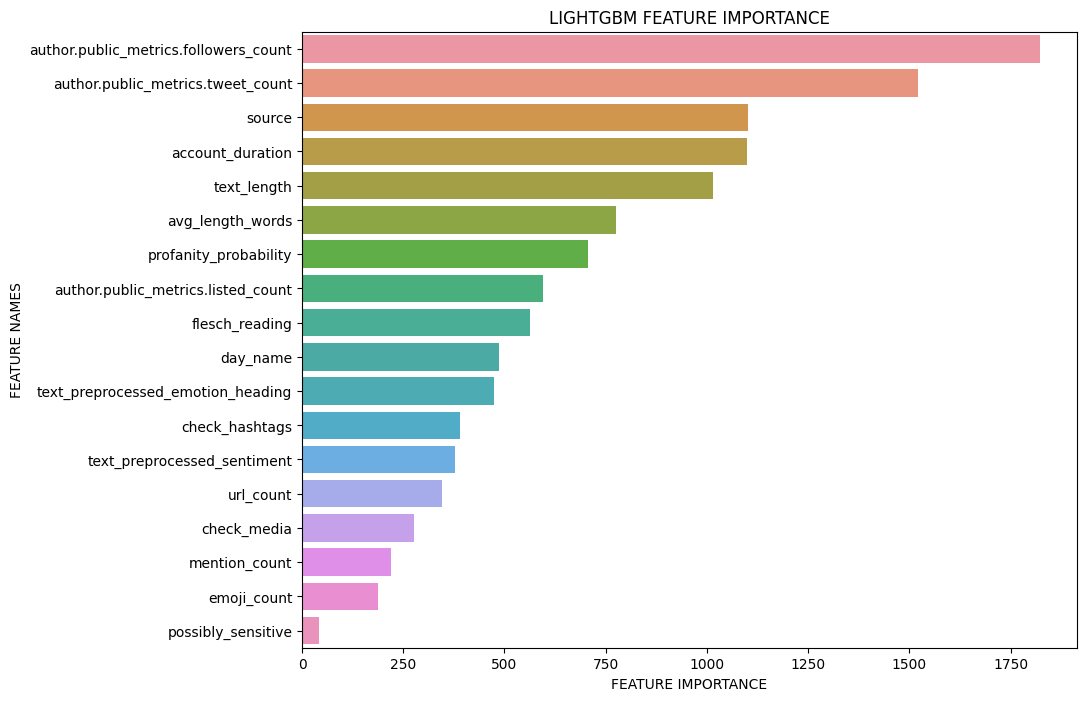

In [ ]:
#plot the catboost result
plot_feature_importance(clf.feature_importances_,X_train.columns,'LIGHTGBM ')